In [1]:
import pandas as pd

# This should contain: vendor, post_text, timestamp, views
df = pd.read_csv("C:/Users/techin/Amharic-NER-Data-Collector_week4/data/proccesed/cleaned_telegram_data.csv")
df.rename(columns={'Channel Title': 'vendor', 'Date': 'timestamp', 'Message': 'post_text'}, inplace=True)

# Ensure correct types
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.dropna(subset=['normalized_message'])

In [2]:
from transformers import pipeline
model_path =  r"C:\Users\techin\Amharic-NER-Data-Collector_week4\notebooks\ner_model\final_model"

ner_pipeline = pipeline("ner", model=model_path, tokenizer=model_path, aggregation_strategy="simple")

def extract_entities(text):
    results = ner_pipeline(text)
    products = [r['word'] for r in results if r['entity_group'] == 'Product']
    prices = [float(r['word'].replace('ETB', '').replace(',', '').strip())
              for r in results if r['entity_group'] == 'Price' and r['word'].replace(',', '').strip().replace('ETB', '').replace('.', '').isdigit()]
    return products, prices

c:\Users\techin\Amharic-NER-Data-Collector_week4\ethio_mart_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df.columns

Index(['vendor', 'Channel Username', 'ID', 'post_text', 'timestamp',
       'Media Path', 'cleaned_message', 'normalized_message', 'tokens'],
      dtype='object')

In [5]:
df[['products', 'prices']] = df['cleaned_message'].apply(lambda x: pd.Series(extract_entities(x)))
df['price'] = df['prices'].apply(lambda x: x[0] if x else None)
df['price'] = pd.to_numeric(df['price'], errors='coerce')

In [14]:
df['week'] = df['timestamp'].dt.to_period('W')
posts_per_week = df.groupby(['vendor', 'week']).size().groupby('vendor').mean()

C:\Users\techin\AppData\Local\Temp\ipykernel_1344\23804611.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['week'] = df['timestamp'].dt.to_period('W')


In [15]:
avg_price = df.groupby('vendor')['price'].mean()

In [16]:
avg_price

vendor
HellooMarket      6082.807540
NEVA COMPUTER®    2107.207762
Shewa Brand         57.271632
Zemen Express®     284.796344
ልዩ እቃ              549.076914
Name: price, dtype: float64

In [18]:
import numpy as np
np.random.seed(42) # for reproducibility
df['views'] = np.random.randint(500, 5000, size=len(df))

In [19]:
top_post = df.loc[df.groupby('vendor')['views'].idxmax()]

In [20]:
from sklearn.preprocessing import MinMaxScaler

score_df = pd.DataFrame({
    'posts_per_week': posts_per_week,
    'avg_price': avg_price
}).fillna(0)

scaler = MinMaxScaler()
score_df[['norm_posts', 'norm_price']] = scaler.fit_transform(score_df[['posts_per_week', 'avg_price']])

# Example: give 70% weight to activity, 30% to price level
score_df['lending_score'] = (score_df['norm_posts'] * 0.7 + score_df['norm_price'] * 0.3)

In [21]:
score_df['lending_score']

vendor
HellooMarket      0.690989
NEVA COMPUTER®    0.177887
Shewa Brand       0.000000
Zemen Express®    0.711328
ልዩ እቃ             0.406352
Name: lending_score, dtype: float64

In [22]:
score_df = score_df[['posts_per_week', 'avg_price', 'lending_score']].round(2)
score_df.reset_index(inplace=True)
score_df.columns = ['Vendor', 'Posts/Week', 'Avg. Price (ETB)', 'Lending Score']
print(score_df.sort_values('Lending Score', ascending=False))

           Vendor  Posts/Week  Avg. Price (ETB)  Lending Score
3  Zemen Express®       18.23            284.80           0.71
0    HellooMarket       14.21           6082.81           0.69
4           ልዩ እቃ       14.09            549.08           0.41
1  NEVA COMPUTER®       10.10           2107.21           0.18
2     Shewa Brand        9.11             57.27           0.00


In [23]:
top_post_df = df.groupby('vendor').apply(lambda x: x.iloc[0])[['post_text', 'products', 'price']]
top_post_df.reset_index(inplace=True)

C:\Users\techin\AppData\Local\Temp\ipykernel_1344\1664623564.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_post_df = df.groupby('vendor').apply(lambda x: x.iloc[0])[['post_text', 'products', 'price']]


C:\Users\techin\AppData\Local\Temp\ipykernel_1344\2279390720.py:6: UserWarning: Glyph 4621 (\N{ETHIOPIC SYLLABLE LE}) missing from current font.
  plt.tight_layout()
C:\Users\techin\AppData\Local\Temp\ipykernel_1344\2279390720.py:6: UserWarning: Glyph 4841 (\N{ETHIOPIC SYLLABLE YU}) missing from current font.
  plt.tight_layout()
C:\Users\techin\AppData\Local\Temp\ipykernel_1344\2279390720.py:6: UserWarning: Glyph 4773 (\N{ETHIOPIC SYLLABLE GLOTTAL E}) missing from current font.
  plt.tight_layout()
C:\Users\techin\AppData\Local\Temp\ipykernel_1344\2279390720.py:6: UserWarning: Glyph 4675 (\N{ETHIOPIC SYLLABLE QAA}) missing from current font.
  plt.tight_layout()
c:\Users\techin\Amharic-NER-Data-Collector_week4\ethio_mart_env\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 4621 (\N{ETHIOPIC SYLLABLE LE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\techin\Amharic-NER-Data-Collector_week4\ethio_mart_env\Lib\site-packages\IPython\core

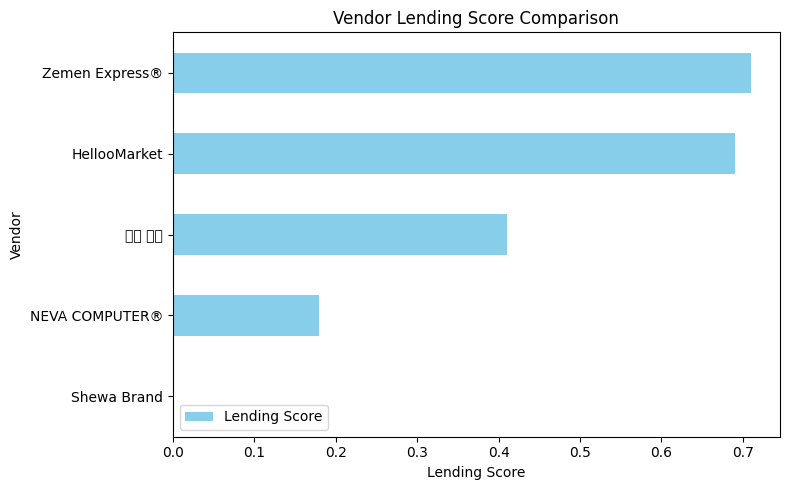

In [24]:
import matplotlib.pyplot as plt

score_df.sort_values('Lending Score').plot.barh(x='Vendor', y='Lending Score', figsize=(8, 5), color='skyblue')
plt.title("Vendor Lending Score Comparison")
plt.xlabel("Lending Score")
plt.tight_layout()
plt.show()